---
<font size="20"><center>How to make BSH data ATMODAT-compliant<br></font></center>
<p style="font-family: Arial; font-size:1.9em;color:gray;text-align:center"> version 1 </p>
<center>Angelika Heil, DKRZ; last edited Oct 22, 2021</center>
<center>Tested on DKRZ jupyterhub with using Python 3 bleeding edge kernel (module anaconda3/bleeding_edge)</center>

TODO:
* Wind direction as numeric with bounds
* Add geometry

# Load required libraries

In [1]:
import os, glob
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"              #-- to show all outputs in a single cell

# Input Data

## Get annual ascii files

**Data description:**https://www.bsh.de/DE/DATEN/Klima-und-Meer/Wetterlagen-und-Stuerme/wetterlagen-und-stuerme_node.html


## Define input data

### Hard-code file information

In [4]:
folder = "data/BSH"        #-- folder where input data are stored
fnroot = "lwtns06"         #-- file name root
ifiles = sorted(glob.glob(folder+'/'+fnroot+'_????.dat'))

### Hard-code missing header info

In [5]:
lwtvars  = [ 'lamb', 'flowdir', 'winddir', 'stormsev' ]
datevars = ['year', 'month', 'day']
headers  = datevars + lwtvars
headers
colspecs = [ (0,4), (5,7), (8,10), (11,13), (14,16), (17,19), (20,23)]

['year', 'month', 'day', 'lamb', 'flowdir', 'winddir', 'stormsev']

### Hard-code variable metadata: long_names and units

In [6]:
# long name
lwtvars_ln = ['lamb weather type', 'flow direction', 'wind direction', 'storm severity']
# units
lwtvars_un = ['1', '1', '1', '1']
# https://doi.org/10.1088/0026-1394/52/1/40: in SI, dimensionless quantities are deemed to have no unit or the coherent derived unit 'one'. 
# fill value
lwtvars_fl = [-9999]*len(lwtvars)


### Define with what numeric values the variables will be encoded

In [7]:
lwtvars_cd = [[1, 1], [-1, 2], [10, 10], [0, 100]]   #-- parameters start and step in range(start, stop, step)

# Read in all input files into a single pandas dataframe

In [8]:
idf         = pd.concat([pd.read_fwf(ifile,index_col=None,header=None, colspecs=colspecs) 
                  for ifile in ifiles],sort=False)
idf.columns = headers
idf['time'] = pd.to_datetime(idf[datevars])    #-- alternatively idf.index=

In [9]:
df          = idf.drop(datevars, axis = 1)

In [10]:
df.head(4)
#print(df.lamb.dtype)   #-- dtype('O'), i.e. pandas objects, which corresponds to Numpy string_, or unicode_ types.

,lamb,flowdir,winddir,stormsev,time
0,SW,C,SW,NUL,1948-01-01
1,C,C,SW,NUL,1948-01-02
2,NW,A,NW,NUL,1948-01-03
3,SW,C,SW,NUL,1948-01-04


# Recode the data using flag_values and flag_meanings

## Plot frequency distribution of classes in each variable

Text(0.5, 0.98, 'Frequency distribution as histograms (period)')

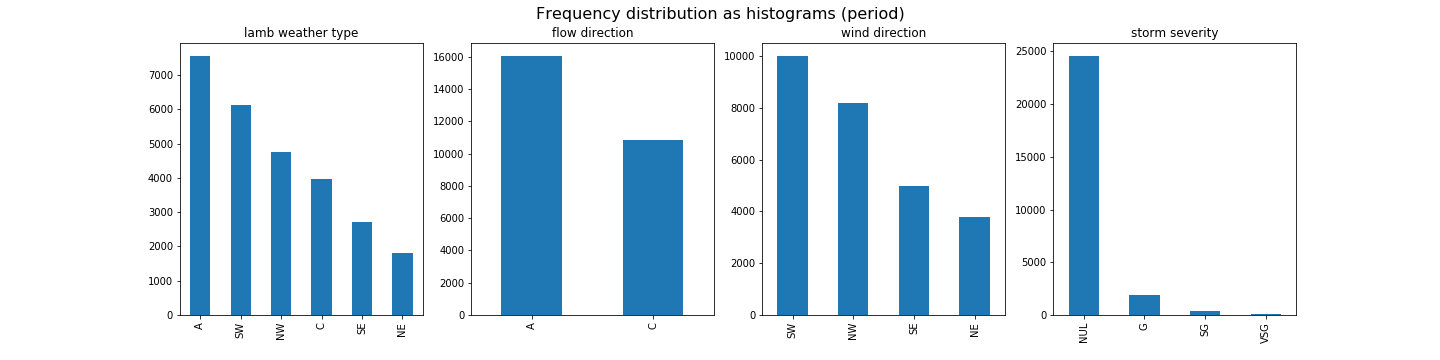

In [11]:
figsiz = 5
nrows, ncols = 1, len(lwtvars)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*figsiz,nrows*figsiz))
fig.suptitle('Frequency distribution as histograms (period)', fontsize=16)
for varindex in range(len(lwtvars)):
    stdout = df[lwtvars[varindex]].value_counts().plot(kind='bar', ax=axes[varindex], title=lwtvars_ln[varindex])

## Create dictionaries with flag_values and flag_meanings for variable and recode data

In [12]:
vardict = dict((lwtvars[varindex], {}) for varindex in range(len(lwtvars)))

for varindex in range(len(lwtvars)):
    freqbyclass = df[lwtvars[varindex]].value_counts()
    #-- NB: arange would create int64 object which cannot be written to json
    codes       = range(lwtvars_cd[varindex][0], lwtvars_cd[varindex][0] + len(freqbyclass) * lwtvars_cd[varindex][1], 
                        lwtvars_cd[varindex][1])
    flagdict    = dict(zip(freqbyclass.index, codes))  
    vardict[lwtvars[varindex]].update(flagdict)
    
    print(vardict[lwtvars[varindex]].values())
    df = df.replace({ lwtvars[varindex]: flagdict })  #-- the replace argument is a nested directory

    print(f'\
The {fnroot} BSH {lwtvars[varindex]} variable contains in total {len(freqbyclass)} classes.\n\
These are: {freqbyclass.index.values}')
    print(f'\
The following encoding will be used {flagdict}')

    

dict_values([1, 2, 3, 4, 5, 6])
The lwtns06 BSH lamb variable contains in total 6 classes.
These are: ['A' 'SW' 'NW' 'C' 'SE' 'NE']
The following encoding will be used {'A': 1, 'SW': 2, 'NW': 3, 'C': 4, 'SE': 5, 'NE': 6}
dict_values([-1, 1])
The lwtns06 BSH flowdir variable contains in total 2 classes.
These are: ['A' 'C']
The following encoding will be used {'A': -1, 'C': 1}
dict_values([10, 20, 30, 40])
The lwtns06 BSH winddir variable contains in total 4 classes.
These are: ['SW' 'NW' 'SE' 'NE']
The following encoding will be used {'SW': 10, 'NW': 20, 'SE': 30, 'NE': 40}
dict_values([0, 100, 200, 300])
The lwtns06 BSH stormsev variable contains in total 4 classes.
These are: ['NUL' 'G' 'SG' 'VSG']
The following encoding will be used {'NUL': 0, 'G': 100, 'SG': 200, 'VSG': 300}


In [13]:
df.head(4)

,lamb,flowdir,winddir,stormsev,time
0,2,1,10,0,1948-01-01
1,4,1,10,0,1948-01-02
2,3,-1,20,0,1948-01-03
3,2,1,10,0,1948-01-04


## Save nested dictionary with flag encodings as json file

In [14]:
with open(fnroot+'_flagcodes.json', 'w') as fp:
    json.dump(vardict, fp)

# Edit metadata

## Convert pandas dataframe to xarray dataset

In [15]:
ds = df.set_index(['time']).to_xarray()

## Encoding for data variables

In [16]:
varenc     = dict(zlib=False, complevel=1, dtype='i4', _FillValue= -9999)
varsenc    = {var: varenc for var in ds.data_vars}

## Encoding for coordinate variables

In [17]:
dimenc     = dict(zlib=False, complevel=1, dtype='i4', _FillValue=None)
dimsenc    = {var: varenc for var in ds.dims}

## Data variable metadata

In [18]:
for count, var in enumerate(lwtvars):
    ds[var].attrs = {'flag_meanings': str(list(vardict[var].keys())).replace('[','').replace(']','').replace("'", ''), 
                     'flag_values': list(vardict[var].values()),
                     'long_name:': lwtvars_ln[count],
                     'units:': lwtvars_un[count]}

## Global metadata

### Get columns requirements and BSH entry from excel file

In [19]:
pdglat    = pd.read_excel(open('Metadata_for_atmodat_standard_BSH_PL_AH.xlsx', 'rb'),
              sheet_name='data_files', header=2, nrows=31, usecols=[1, 8])  

### Remove all rows that have NaN entry

In [20]:
glat      = pdglat[pdglat.iloc[:, 1].str.contains("NaN")==0]

### Create dictionary with all global attributes

In [21]:
dictglat  = dict(zip(glat.iloc[0:, 0].str.strip(),glat['BSH entry']))
#-- add quotation .apply(lambda x: "'" + str(x) + "'"))) or glat.update(glat[['BSH entry']].applymap('"{}"'.format)) # glat.iloc[1:, 1]))

### Write global attributes into xarray dataset

In [23]:
ds.attrs = dictglat  #-- select first 2 dictionary elements: dict(list(dictglat.items())[:2])

## Metadata of coordinate variables

In [24]:
ds['time'].attrs={'standard_name':'time', 'long_name':'Time'}

# Write out data as netCDF

In [25]:
ds.to_netcdf(f"{folder}/{fnroot}.nc", encoding={**varsenc, **dimsenc})


## Write out annual files

In [26]:
years, datasets = zip(*ds.groupby("time.year"))
# paths = [f"{fnroot}_{y}.nc" for y in years]; xr.save_mfdataset(datasets, paths)  #--> cannot use encoding!! 
for count, year in enumerate(years):
    datasets[count].to_netcdf(f"{folder}/{fnroot}_{year}.nc", encoding={**varsenc, **dimsenc})

In [27]:
!ncdump -h $folder/lwtns06_1952.nc

netcdf lwtns06_1952 {
dimensions:
	time = 366 ;
variables:
	int time(time) ;
		time:_FillValue = -9999 ;
		time:standard_name = "time" ;
		time:long_name = "Time" ;
		time:units = "days since 1952-01-01 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;
	int lamb(time) ;
		lamb:_FillValue = -9999 ;
		lamb:flag_meanings = "A, SW, NW, C, SE, NE" ;
		lamb:flag_values = 1LL, 2LL, 3LL, 4LL, 5LL, 6LL ;
		lamb:long_name\: = "lamb weather type" ;
		lamb:units\: = "1" ;
	int flowdir(time) ;
		flowdir:_FillValue = -9999 ;
		flowdir:flag_meanings = "A, C" ;
		flowdir:flag_values = -1LL, 1LL ;
		flowdir:long_name\: = "flow direction" ;
		flowdir:units\: = "1" ;
	int winddir(time) ;
		winddir:_FillValue = -9999 ;
		winddir:flag_meanings = "SW, NW, SE, NE" ;
		winddir:flag_values = 10LL, 20LL, 30LL, 40LL ;
		winddir:long_name\: = "wind direction" ;
		winddir:units\: = "1" ;
	int stormsev(time) ;
		stormsev:_FillValue = -9999 ;
		stormsev:flag_meanings = "NUL, G, SG, VSG" ;
		stormsev:flag_values 

In [28]:
!cdo infov $folder/lwtns06_1952.nc

    -1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter name
     1 : 1952-01-01 00:00:00       0        1       0 :                  2.0000             : lamb          
     2 : 1952-01-01 00:00:00       0        1       0 :                  1.0000             : flowdir       
     3 : 1952-01-01 00:00:00       0        1       0 :                  10.000             : winddir       
     4 : 1952-01-01 00:00:00       0        1       0 :                  0.0000             : stormsev      
     5 : 1952-01-02 00:00:00       0        1       0 :                  4.0000             : lamb          
     6 : 1952-01-02 00:00:00       0        1       0 :                  1.0000             : flowdir       
     7 : 1952-01-02 00:00:00       0        1       0 :                  10.000             : winddir       
     8 : 1952-01-02 00:00:00       0        1       0 :                  0.0000             : stormsev      
     9 : 1952-01-03